In [2]:
import pyspark
import os.path

In [3]:
sc = pyspark.SparkContext(master="local[1]",appName='metyis_challenge')

In [4]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [5]:
# Vamos a definir un schema personalizado para poder tratar las fechas convenientemente
from pyspark.sql.types import *

bixiSchema = StructType([ \
                StructField("_c0", DoubleType(), True), \
                StructField("start_date", DateType(), True), \
                StructField("start_station_code", StringType(), True), \
                StructField("end_date", DateType(), True), \
                StructField("end_station_code", StringType(), True), \
                StructField("duration_sec", DoubleType(), True), \
                StructField("is_member", BooleanType(), True)])

In [35]:
bixiDF = sqlContext.read.format('csv').options(header='true', delimiter = ',') \
        .load('./data/OD_2014.csv', schema = bixiSchema)

print(bixiDF.count())
bixiDF.take(3)

3136276


[Row(_c0=0.0, start_date=datetime.date(2014, 4, 15), start_station_code='6209', end_date=datetime.date(2014, 4, 15), end_station_code='6436', duration_sec=1061.0, is_member=None),
 Row(_c0=1.0, start_date=datetime.date(2014, 4, 15), start_station_code='6214', end_date=datetime.date(2014, 4, 15), end_station_code='6248', duration_sec=615.0, is_member=None),
 Row(_c0=2.0, start_date=datetime.date(2014, 4, 15), start_station_code='6164', end_date=datetime.date(2014, 4, 15), end_station_code='6216', duration_sec=1031.0, is_member=None)]

In [36]:
bixiDF.describe().show()

+-------+-----------------+------------------+------------------+-----------------+
|summary|              _c0|start_station_code|  end_station_code|     duration_sec|
+-------+-----------------+------------------+------------------+-----------------+
|  count|          3136276|           3136276|           3136276|          3136276|
|   mean|        1568137.5|  6237.94442134557| 6231.226863643378|789.7391029998636|
| stddev|905365.0407640373|273.04065261969197|281.75890464523695|627.6714220519676|
|    min|              0.0|             10002|             10002|             61.0|
|    max|        3136275.0|              6929|              6929|           7195.0|
+-------+-----------------+------------------+------------------+-----------------+



In [37]:
display(bixiDF)

DataFrame[_c0: double, start_date: date, start_station_code: string, end_date: date, end_station_code: string, duration_sec: double, is_member: boolean]

In [38]:
year = '2014'

In [39]:
sqlContext.sql('DROP TABLE IF EXISTS metyis_bixi_travels')
sqlContext.registerDataFrameAsTable(bixiDF, 'metyis_bixi_travels')

In [40]:
# durations = sqlContext.sql('SELECT min(month(start_date)) as month, sum(duration_sec) \
#        FROM metyis_bixi_travels')
# durations.take(10)

[Row(month=4, sum(duration_sec)=2476839795.0)]

In [76]:
durations = sqlContext.sql('SELECT \
        start_date as date, avg(duration_sec) as time \
        FROM metyis_bixi_travels \
        WHERE year(start_date) ={} \
        GROUP BY start_date \
        ORDER BY date'\
        .format(year))
durations.take(10)

[Row(date=4, time=725.5070383506983),
 Row(date=5, time=799.1206648493941),
 Row(date=6, time=832.9655290446372),
 Row(date=7, time=822.1203842262782),
 Row(date=8, time=835.3192805057653),
 Row(date=9, time=761.46314588154),
 Row(date=10, time=694.5260624800343),
 Row(date=11, time=621.2702324203495)]

In [66]:
from matplotlib import pyplot as plt
import pandas as pd

durationsDF = pd.DataFrame(durations.toPandas(), columns=['date', 'time'])
#durationsDF['ts'] = durationsDF["date"].astype("datetime64")
durationsDF.head()


# durationsDF.plot.hist(y='ts', x='time')

,date,time
0,2014-04-15,625.173748
1,2014-04-16,632.188994
2,2014-04-17,679.465140
3,2014-04-18,723.642441
4,2014-04-19,862.890068


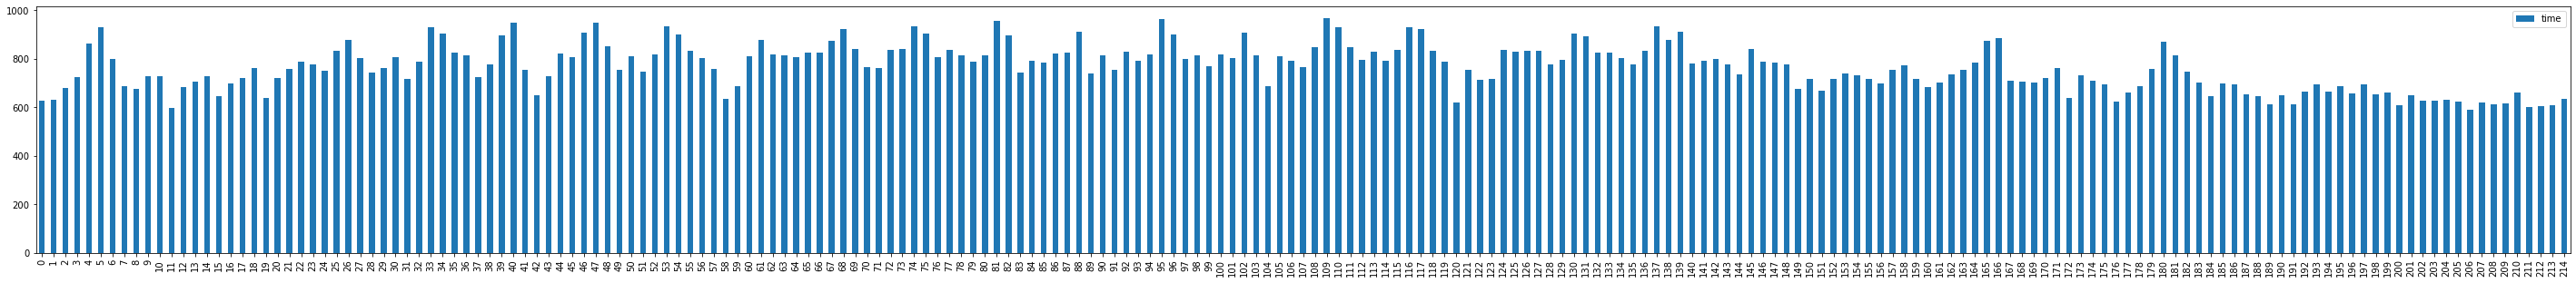

In [75]:
fig, ax = plt.subplots(figsize=(50, 5))

durations_plot = durationsDF.plot(kind="bar",ax=ax)
